# Collaborative Filtering Recommender System

# Outline
- [ 1 - Notation](#1)
- [ 2 - Downloading the Dataset](#2)
- [ 3 - Analysis of the Data](#3)
- [ 4 - Preparing the Training Data](#4)
- [ 5 - Cost Function](#5)
- [ 6 - Training the Model](#6)
- [ 7 - Recommendations](#7)




##  Packages
Importing the packages required for this project.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import requests
from zipfile import ZipFile
import matplotlib.pyplot as plt

<a name="1"></a>
## 1 - Notation


|General <br />  Notation  | Description| Python (if any) |
|:-------------|:------------------------------------------------------------||
| $r(i,j)$     | scalar; = 1  if user j rated movie i  = 0  otherwise             ||
| $y(i,j)$     | scalar; = rating given by user j on movie  i    (if r(i,j) = 1 is defined) ||
|$\mathbf{w}^{(j)}$ | vector; parameters for user j ||
|$b^{(j)}$     |  scalar; parameter for user j ||
| $\mathbf{x}^{(i)}$ |   vector; feature ratings for movie i        ||     
| $n_u$        | number of users |num_users|
| $n_m$        | number of movies | num_movies |
| $n$          | number of features | num_features                    |
| $\mathbf{X}$ |  matrix of vectors $\mathbf{x}^{(i)}$         | X |
| $\mathbf{W}$ |  matrix of vectors $\mathbf{w}^{(j)}$         | W |
| $\mathbf{b}$ |  vector of bias parameters $b^{(j)}$ | b |
| $\mathbf{R}$ | matrix of elements $r(i,j)$                    | R |



<a name="2"></a>
## 2 - Downloading the Dataset 
The data set is derived from the [MovieLens "ml-latest-small"](https://grouplens.org/datasets/movielens/latest/) dataset.   
[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The dataset has 9742 movies rated by 610 users.

The dataset comes as a .zip file. Let's first download the dataset using the request module.

In [2]:
# specifying the url of the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# downloaing the file
r = requests.get(url, allow_redirects=True)

#opening the file and saving the contents
open('ml-latest-small.zip', 'wb').write(r.content)

978202

In [3]:
# specifying the zip file name
file_name = "ml-latest-small.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipp:
    # printing all the contents of the zip file
    zipp.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zipp.extractall()
    print('Done!')

File Name                                             Modified             Size
ml-latest-small/                               2018-09-26 15:50:12            0
ml-latest-small/links.csv                      2018-09-26 15:50:10       197979
ml-latest-small/tags.csv                       2018-09-26 15:49:40       118660
ml-latest-small/ratings.csv                    2018-09-26 15:49:38      2483723
ml-latest-small/README.txt                     2018-09-26 15:50:12         8342
ml-latest-small/movies.csv                     2018-09-26 15:49:56       494431
Extracting all the files now...
Done!


<a name="3"></a>
## 3 - Analysis of the Data

Let's first have a look at the data. There are 4 different tables in the main table:<br />
1.links<br />
2.tags<br />
3.ratings<br />
4.movies<br />

Let's start with the links table first:

In [4]:
links_df = pd.read_csv('ml-latest-small/links.csv')
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [5]:
links_df.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


It can be seen that the links table contains infomration about the ID of the film in IMDB and The Movie Database. 

In [6]:
tags_df = pd.read_csv('ml-latest-small/tags.csv')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [7]:
tags_df.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


As can be seen, each row in the tags table contains a tag about one movie by one user. The tag is either one word or an expression. 

In [8]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [31]:
movies_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Overall there are 9742 movies in the dataset.

In [10]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
pd.unique(ratings_df['movieId']).shape

(9724,)

In [13]:
pd.unique(ratings_df['userId']).shape

(610,)

We saw that there are 9742 movies in the dataset; however, the ratings table only has 9724 different movies, so not all of the movies are rated but all of the users have rated at least 1 movie. 

For this project, we will be using the ratings table to create our training data. Each row in the ratings table contains the rating of one mivie by one user. The lines within this file are ordered first by userId, then, within user, by movieId. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. In total, there are 100836 ratings in the table.

<a name="4"></a>
## 4 - Preparing the Training Data

As mentioned before, we will be using the ratings table to create our training data. We basically need to create 2 different matrices, the ratings matrix, Y, and the element mask matrix, R. The rows in the Y matrix refer to each movie and the columns refer to the users. So, for any i and j, Y(i,j) is the rating given to movie i by user j. If the user has not rated a movie, then Y(i,j) is zero for that pair. The mask matrix, R, has the same structure as Y. Each element in R basically shows if a certain user has rated a certain movie. If a rating exists for the user j and movie i, then R(i,j) = 1 and else it will be zero. Now let's use the ratings_df dataframe to create the ratings matrix. 

In [76]:
# extracting the number of users and the number of movies with a rating
num_of_users = pd.unique(ratings_df['userId']).shape[0]
num_of_movies = pd.unique(ratings_df['movieId']).shape[0]

# creating the  initial Y and R matrices and intializing their elemnts as 0
Y = np.zeros((num_of_movies,num_of_users))
R_train = np.zeros((num_of_movies,num_of_users))
R_validation = np.zeros((num_of_movies,num_of_users))

In order to be able to create Y and R and to later add our own ratings to the model we create a dataframe containing the movies with a rating. This dataframe includes the movie Id and the title of the movie. 

In [136]:
rated_movies_df  =  movies_df.loc[movies_df.isin(list(ratings_df['movieId']))['movieId'],:]
rated_movies_df.reset_index(inplace=True,drop = True)
rated_movies_df.loc[rated_movies_df['title']=='Toy Story 3 (2010)',:]

,movieId,title,genres
7338,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


In [78]:
# extracting the correspoding index of each movie in the movieId column of the ratings_df dataframe in the rated_movies_df dataframe 
ratings_df_train = ratings_df.sample(frac = 0.8)
ratings_df_validation = ratings_df.drop(ratings_df_train.index)

movie_id_list_train = []
movie_id_list_validation = []

for i in range (0,ratings_df_train['movieId'].shape[0]):
    movie_id_list_train.append(rated_movies_df.loc[rated_movies_df['movieId'] == ratings_df_train.iloc[i,1],'movieId'].index.values[0])

for i in range (0,ratings_df_validation['movieId'].shape[0]):
    movie_id_list_validation.append(rated_movies_df.loc[rated_movies_df['movieId'] == ratings_df_validation.iloc[i,1],'movieId'].index.values[0])
    

In [79]:
# creating the R and Y matrices

R_train[movie_id_list_train,ratings_df_train['userId']-1] = 1

R_validation[movie_id_list_validation,ratings_df_validation['userId']-1] = 1

for i in range (0,num_of_movies):
    for j in range (0,num_of_users):
        
        if (R_train[i,j] == 1) or (R_validation[i,j] == 1):
            Y[i,j] = ratings_df.loc[(ratings_df['movieId'] == rated_movies_df.iloc[i,0] ) & (ratings_df['userId'] == j+1),'rating'].values[0]
        
        

In [94]:
Y.shape

1.0

<a name="5"></a>
## 5 - Cost Function

Now, we will begin implementing the cost function for the collaborative filtering learning
algorithm.

We consider a set of $n$-dimensional parameter vectors
$\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)}$, $\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$ and $b^{(0)},...,b^{(n_u-1)}$, where the
model predicts the rating for movie $i$ by user $j$ as
$y^{(i,j)} = \mathbf{w}^{(j)}\cdot \mathbf{x}^{(i)} + b^{(j)}$ . Given a dataset that consists of
a set of ratings produced by some users on some movies, we wish to
learn the parameter vectors $\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},
\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$  and $b^{(0)},...,b^{(n_u-1)}$ that produce the best fit (minimizes
the squared error).

The cost function used for this filter is:
$$J({\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},\mathbf{w}^{(0)},b^{(0)},...,\mathbf{w}^{(n_u-1)},b^{(n_u-1)}})= \left[ \frac{1}{2}\sum_{(i,j):r(i,j)=1}(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+ \underbrace{\left[
\frac{\lambda}{2}
\sum_{j=0}^{n_u-1}\sum_{k=0}^{n-1}(\mathbf{w}^{(j)}_k)^2
+ \frac{\lambda}{2}\sum_{i=0}^{n_m-1}\sum_{k=0}^{n-1}(\mathbf{x}_k^{(i)})^2
\right]}_{regularization}
\tag{1}$$
The first summation in (1) is "for all $i$, $j$ where $r(i,j)$ equals $1$" and could be written:

$$
= \left[ \frac{1}{2}\sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+\text{regularization}
$$

Please note that the parameter vectors could be used to build the parameter matrices:

$$\mathbf{X} = 
\begin{bmatrix}
--- (\mathbf{x}^{(0)})^T --- \\
--- (\mathbf{x}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{x}^{(n_m-1)})^T --- \\
\end{bmatrix} , \quad
\mathbf{W} = 
\begin{bmatrix}
--- (\mathbf{w}^{(0)})^T --- \\
--- (\mathbf{w}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{w}^{(n_u-1)})^T --- \\
\end{bmatrix},\quad
\mathbf{ b} = 
\begin{bmatrix}
 b^{(0)}  \\
 b^{(1)} \\
\vdots \\
b^{(n_u-1)} \\
\end{bmatrix}\quad
$$ 


The following function calculates the cost for the whole system at any given point. 

In [81]:
def cost_func(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

<a name="6"></a>
## 6 - Training the Model

Before we start training the model. Let's create a list of our own favourite movies and add to the dataset which will later help us to evaluate the model. To do this we can use the rated_movies_df dataframe.

In [137]:
my_ratings = np.zeros(num_of_movies)          #  Initialize my ratings

# Check the rated_movies_df dataframe for index of each movie in our dataset
# For example, Toy Story 3 (2010) has index 1133, so to rate it "5", you can set
my_ratings[7338] = 5 

#Or suppose you did not enjoy Persuasion (2007), you can set
my_ratings[3469] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[774]  = 5   # Lord of the Rings: The Return of the King, The (2003)
my_ratings[4306]  = 5   # Shrek (2001)
my_ratings[244] = 4   # Inception (2010)
my_ratings[794] = 5   # Incredibles, The (2004)
my_ratings[4973]  = 2   # Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
my_ratings[4896]  = 5   # Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
my_ratings[763]  = 5   # Harry Potter and the Chamber of Secrets (2002)
my_ratings[7361]  = 5   # Eternal Sunshine of the Spotless Mind (2004)
my_ratings[7675] = 1   # Louis Theroux: Law & Disorder (2008)
my_ratings[6826] = 1   # Nothing to Declare (Rien à déclarer) (2010)
my_ratings[770]  = 4   # Pirates of the Caribbean: The Curse of the Black Pearl (2003)
my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(f'Rated {my_ratings[i]} for  {rated_movies_df.iloc[i,1]}');


New user ratings:

Rated 4.0 for  Nell (1994)
Rated 5.0 for  D3: The Mighty Ducks (1996)
Rated 4.0 for  Old Yeller (1957)
Rated 5.0 for  Shaggy Dog, The (1959)
Rated 5.0 for  Lawnmower Man, The (1992)
Rated 2.0 for  Maybe Baby (2000)
Rated 5.0 for  Flickering Lights (Blinkende lygter) (2000)
Rated 5.0 for  Wilbur Wants to Kill Himself (2002)
Rated 2.0 for  Noises Off... (1992)
Rated 1.0 for  Bangkok Dangerous (2008)
Rated 5.0 for  Toy Story 3 (2010)
Rated 5.0 for  Serbian Film, A (Srpski film) (2010)
Rated 1.0 for  Avengers, The (2012)


Now, let's add these reviews to $Y$ and $R$ and normalize the ratings.

In [83]:
# Add new user ratings to Y 
Y = np.c_[my_ratings, Y]

# Add new user indicator matrix to R
R_train = np.c_[(my_ratings != 0).astype(int), R_train]
R_validation = np.c_[np.zeros(num_of_movies) , R_validation]
R = R_train+R_validation
# Normalize the Dataset
Ymean = (np.sum(Y*R,axis=1)/(np.sum(R, axis=1)+1e-12)).reshape(-1,1)
Ynorm = Y - np.multiply(Ymean, R) 

In [97]:
Ymean

array([[3.92093023],
       [3.43181818],
       [3.25961538],
       ...,
       [3.5       ],
       [3.5       ],
       [4.        ]])

Let's prepare to train the model. Initialize the parameters and select the Adam optimizer.

In [130]:
#  Useful Values
num_movies, num_users = Y.shape
num_features = 500

# Set Initial Parameters (W, X), use tf.Variable to track these variables
W = tf.Variable(tf.random.normal((num_users,  num_features),dtype=tf.float64),  name='W')
X = tf.Variable(tf.random.normal((num_movies, num_features),dtype=tf.float64),  name='X')
b = tf.Variable(tf.random.normal((1,          num_users),   dtype=tf.float64),  name='b')

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

Let's now train the collaborative filtering model. This will learn the parameters $\mathbf{X}$, $\mathbf{W}$, and $\mathbf{b}$. 

The operations involved in learning $w$, $b$, and $x$ simultaneously do not fall into the typical layers offered in the TensorFlow neural network package. So, instead, we will use GradientTape and the following method: 

- repeat until convergence:
    - compute forward pass
    - compute the derivatives of the loss relative to parameters
    - update the parameters using the learning rate and the computed derivatives 
   

In [132]:
iterations = 200
lambda_ = 10
train_loss = []
validation_loss = []
itterations_list = []
loss = []
for iter in range(iterations+1):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost 
    with tf.GradientTape() as tape:

        # Compute the cost (forward pass included in cost)
        train_cost = cost_func(X, W, b, Ynorm, R_train, lambda_)
        validation_cost = cost_func(X, W, b, Ynorm, R_validation, lambda_)
        cost = cost_func(X, W, b, Ynorm, R, lambda_)
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient( cost, [X,W,b] )

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients( zip(grads, [X,W,b]) )

    # Log periodically.
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {train_cost:0.1f}")
        print(f"Validation loss at iteration {iter}: {validation_cost:0.1f}")
        print(f"loss at iteration {iter}: {cost:0.1f}")
        train_loss.append(train_cost)
        validation_loss.append(validation_cost)
        loss.append(cost)
        itterations_list.append(iter)


Training loss at iteration 0: 30863118.2
Validation loss at iteration 0: 25906040.3
loss at iteration 0: 32519403.1
Training loss at iteration 20: 3778220.8
Validation loss at iteration 20: 3644912.3
loss at iteration 20: 3822199.8
Training loss at iteration 40: 794370.9
Validation loss at iteration 40: 783886.8
loss at iteration 40: 797998.6
Training loss at iteration 60: 224506.9
Validation loss at iteration 60: 221940.1
loss at iteration 60: 225361.2
Training loss at iteration 80: 88764.0
Validation loss at iteration 80: 86263.1
loss at iteration 80: 89585.8
Training loss at iteration 100: 48623.7
Validation loss at iteration 100: 45192.4
loss at iteration 100: 49751.1
Training loss at iteration 120: 34265.6
Validation loss at iteration 120: 29856.6
loss at iteration 120: 35715.4
Training loss at iteration 140: 28341.5
Validation loss at iteration 140: 23150.6
loss at iteration 140: 30056.2
Training loss at iteration 160: 25604.5
Validation loss at iteration 160: 19847.1
loss at ite

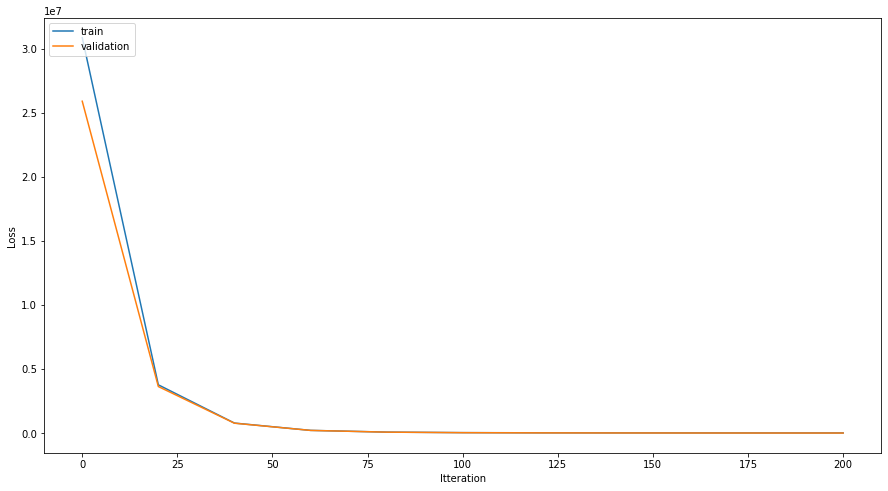

In [133]:
# PLotting the losses
plt.figure(figsize=(15,8))
plt.plot(itterations_list,train_loss)
plt.plot(itterations_list,validation_loss)
plt.xlabel("Itteration")
plt.ylabel("Loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

<a name="7"></a>
## 7 - Recommendations
Below, we compute the ratings for all the movies and users and display the movies that are recommended. These are based on the movies and ratings entered as `my_ratings[]` above. To predict the rating of movie $i$ for user $j$, you compute $\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)}$.

In [134]:
# Make a prediction using trained weights and biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

#restore the mean
pm = p + Ymean

my_predictions = pm[:,0]

# sort predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

for i in range(17):
    j = ix[i].numpy()
    if j not in my_rated:
        print(f'Predicting rating {my_predictions[j]:0.2f} for movie {rated_movies_df.iloc[j,1]}')

print('\n\nOriginal vs Predicted ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {rated_movies_df.iloc[i,1]}')

Predicting rating 5.42 for movie Superman/Batman: Public Enemies (2009)
Predicting rating 5.42 for movie Faster (2010)
Predicting rating 5.42 for movie Wonder Woman (2009)
Predicting rating 5.42 for movie A Detective Story (2003)
Predicting rating 5.42 for movie Justice League: Doom (2012) 
Predicting rating 5.42 for movie Dragons: Gift of the Night Fury (2011)
Predicting rating 5.42 for movie Villain (1971)
Predicting rating 5.42 for movie 7 Faces of Dr. Lao (1964)
Predicting rating 5.42 for movie 20 Million Miles to Earth (1957)
Predicting rating 5.42 for movie American Friend, The (Amerikanische Freund, Der) (1977)
Predicting rating 5.42 for movie Maniac Cop 2 (1990)
Predicting rating 5.42 for movie Last Hurrah for Chivalry (Hao xia) (1979)
Predicting rating 5.42 for movie Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981)
Predicting rating 5.42 for movie Only Lovers Left Alive (2013)
Predicting rating 5.42 for movie Mother (Madeo) (2009)
Predicting rating 5.42 for m